In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from Dilated_Conv_Att import AttDiCEm
from dataset_creation import StockDataset
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [2]:
base_path = "price/raw"
df = pd.read_csv(f"{base_path}/AAPL.csv")
print(len(df))

1258


In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-09-04,95.108574,96.448570,94.928574,96.424286,87.121140,91973000
1,2012-09-05,96.510002,96.621429,95.657143,95.747147,86.509338,84093800
2,2012-09-06,96.167145,96.898575,95.828575,96.610001,87.288956,97799100
3,2012-09-07,96.864288,97.497147,96.538574,97.205711,87.827171,82416600
4,2012-09-10,97.207146,97.612854,94.585716,94.677139,85.542564,121999500


In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['Open','High','Low','Close','Volume']] = scaler.fit_transform(df[['Open','High','Low','Close','Volume']])

In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-09-04,0.362825,0.364963,0.367482,0.375340,87.121140,0.227562
1,2012-09-05,0.375638,0.366566,0.374189,0.369085,86.509338,0.205288
2,2012-09-06,0.372504,0.369136,0.375768,0.377055,87.288956,0.244032
3,2012-09-07,0.378878,0.374685,0.382305,0.382558,87.827171,0.200546
4,2012-09-10,0.382012,0.375758,0.364325,0.359201,85.542564,0.312446


In [6]:
feature_columns = ['Open','High','Low','Close','Volume']
# feature_columns = ['Close']
filtered_df = df[feature_columns]
seq_len = 10
train_size = int(len(filtered_df) * 0.8)
train_data = filtered_df.iloc[:train_size]
test_data = filtered_df.iloc[train_size:]


In [7]:
try:
    train_dataset = StockDataset(train_data, seq_len, feature_columns)
    test_dataset = StockDataset(test_data, seq_len, feature_columns)
    print("Datasets created successfully!")
except Exception as e:
    print(f"Error creating dataset: {e}")

Datasets created successfully!


In [8]:
train_dataset[0]

(tensor([[0.3628, 0.3650, 0.3675, 0.3753, 0.2276],
         [0.3756, 0.3666, 0.3742, 0.3691, 0.2053],
         [0.3725, 0.3691, 0.3758, 0.3771, 0.2440],
         [0.3789, 0.3747, 0.3823, 0.3826, 0.2005],
         [0.3820, 0.3758, 0.3643, 0.3592, 0.3124],
         [0.3620, 0.3583, 0.3570, 0.3564, 0.3237],
         [0.3642, 0.3580, 0.3563, 0.3685, 0.4709],
         [0.3780, 0.3787, 0.3810, 0.3859, 0.3904],
         [0.3944, 0.3939, 0.3982, 0.3969, 0.3919],
         [0.4067, 0.3976, 0.4071, 0.4081, 0.2489]]),
 tensor(0.4109))

In [9]:
from itertools import product
import numpy as np

# Define hyperparameter ranges
param_grid = {
    "hidden_size": [32, 64, 128],
    "kernel_size": [3, 5, 7],
    "dilation_rates": [[1,2,4], [1,2,4,8], [1,2,4,8,16]],
    "num_heads": [2, 4, 8],
    "batch_size": [8, 16, 32],
    "learning_rate": [1e-4, 1e-3, 5e-3],
    "epochs": [20, 50]
}

# Store results
best_loss = float("inf")
best_params = None

# Iterate through all parameter combinations
for params in product(*param_grid.values()):
    # Unpack parameters
    param_dict = dict(zip(param_grid.keys(), params))
    
    print(f"Testing {param_dict}...")

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=param_dict["batch_size"], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=param_dict["batch_size"], shuffle=False)

    # Initialize model
    model = AttDiCEm(
        input_size=len(feature_columns),
        hidden_size=param_dict["hidden_size"],
        kernel_size=param_dict["kernel_size"],
        dilation_rates=param_dict["dilation_rates"],
        num_heads=param_dict["num_heads"]
    )

    # Define loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=param_dict["learning_rate"])

    # Training loop
    for epoch in range(param_dict["epochs"]):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()

    # Evaluate model
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            test_loss += criterion(outputs.squeeze(), targets).item()

    avg_test_loss = test_loss / len(test_loader)

    print(f"Test Loss: {avg_test_loss:.4f}")

    # Store best hyperparameters
    if avg_test_loss < best_loss:
        best_loss = avg_test_loss
        best_params = param_dict

print("\nBest Hyperparameters:", best_params)

Testing {'hidden_size': 32, 'kernel_size': 3, 'dilation_rates': [1, 2, 4], 'num_heads': 2, 'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 20}...
Test Loss: 0.0023
Testing {'hidden_size': 32, 'kernel_size': 3, 'dilation_rates': [1, 2, 4], 'num_heads': 2, 'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 50}...
Test Loss: 0.0017
Testing {'hidden_size': 32, 'kernel_size': 3, 'dilation_rates': [1, 2, 4], 'num_heads': 2, 'batch_size': 8, 'learning_rate': 0.001, 'epochs': 20}...
Test Loss: 0.0002
Testing {'hidden_size': 32, 'kernel_size': 3, 'dilation_rates': [1, 2, 4], 'num_heads': 2, 'batch_size': 8, 'learning_rate': 0.001, 'epochs': 50}...
Test Loss: 0.0003
Testing {'hidden_size': 32, 'kernel_size': 3, 'dilation_rates': [1, 2, 4], 'num_heads': 2, 'batch_size': 8, 'learning_rate': 0.005, 'epochs': 20}...
Test Loss: 0.0003
Testing {'hidden_size': 32, 'kernel_size': 3, 'dilation_rates': [1, 2, 4], 'num_heads': 2, 'batch_size': 8, 'learning_rate': 0.005, 'epochs': 50}...
Test Loss: 0.0

KeyboardInterrupt: 

Epoch 1/50, Loss: 0.0006267170538194478
Epoch 2/50, Loss: 0.0015942300669848919
Epoch 3/50, Loss: 0.00039894983638077974
Epoch 4/50, Loss: 0.0005955659435130656
Epoch 5/50, Loss: 0.001367468386888504
Epoch 6/50, Loss: 0.00010835014836629853
Epoch 7/50, Loss: 0.0007191367330960929
Epoch 8/50, Loss: 0.00048728950787335634
Epoch 9/50, Loss: 0.0009001324651762843
Epoch 10/50, Loss: 0.0010016168234869838
Epoch 11/50, Loss: 4.6558663598261774e-05
Epoch 12/50, Loss: 0.00015444724704138935
Epoch 13/50, Loss: 0.00042712243157438934
Epoch 14/50, Loss: 9.522005711914971e-05
Epoch 15/50, Loss: 6.947955989744514e-05
Epoch 16/50, Loss: 0.0003137952007818967
Epoch 17/50, Loss: 0.00015888149209786206
Epoch 18/50, Loss: 0.0003381398564670235
Epoch 19/50, Loss: 6.052666867617518e-05
Epoch 20/50, Loss: 0.00025460432516410947
Epoch 21/50, Loss: 0.0005420318339020014
Epoch 22/50, Loss: 3.279998054495081e-05
Epoch 23/50, Loss: 0.0007754794787615538
Epoch 24/50, Loss: 0.00030138666625134647
Epoch 25/50, Loss

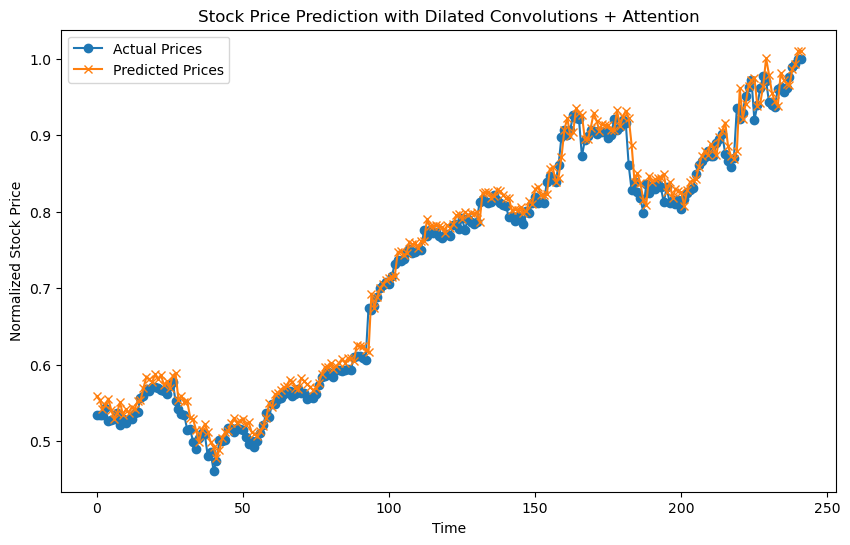

In [11]:
# Define the new model
# Testing {'hidden_size': 32, 'kernel_size': 3, 'dilation_rates': [1, 2, 4], 'num_heads': 8, 'batch_size': 32, 'learning_rate': 0.005, 'epochs': 50}...
# Test Loss: 0.0002
# Testing {'hidden_size': 32, 'kernel_size': 3, 'dilation_rates': [1, 2, 4, 8], 'num_heads': 8, 'batch_size': 8, 'learning_rate': 0.005, 'epochs': 50}...
# Test Loss: 0.0002

input_size = len(feature_columns)  # Number of features
hidden_size = 32  # Number of output channels from CNN
kernel_size=3
dilation_rates=[1, 2, 4,8]
num_heads=8
model = AttDiCEm(input_size=input_size, hidden_size=hidden_size, kernel_size=kernel_size, dilation_rates=dilation_rates, num_heads=num_heads)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# Test the model
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        predictions.extend(outputs.squeeze().numpy())
        actuals.extend(targets.numpy())

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual Prices', marker='o')
plt.plot(predictions, label='Predicted Prices', marker='x')
plt.title('Stock Price Prediction with Dilated Convolutions + Attention')
plt.xlabel('Time')
plt.ylabel('Normalized Stock Price')
plt.legend()
plt.show()